Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

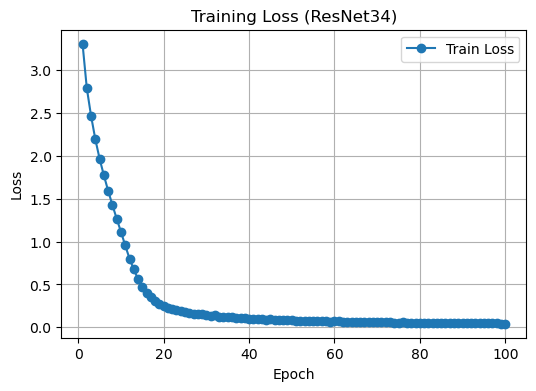

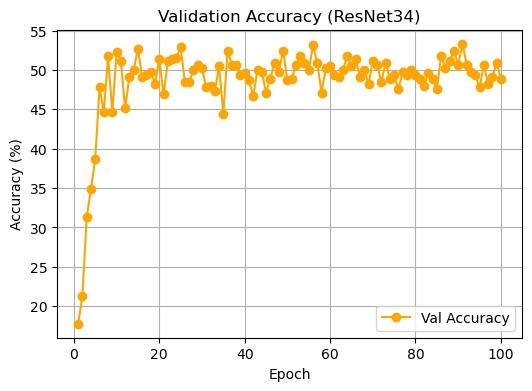


=== Final Results Table ===
| Method   | #Kernels   |   #Param (M) |   MAdds (M) |   Top-1 (%) |
|:---------|:-----------|-------------:|------------:|------------:|
| ResNet34 | N/A        |        21.34 |      614.63 |       50.67 |

Training history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.


In [4]:
# -------------------------------
# 1. 匯入必要套件
# -------------------------------
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
from thop import profile
import pandas as pd

# -------------------------------
# 2. 設定運算裝置 (GPU / CPU)
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 3. 定義讀取 txt 檔案的函式 (讀取圖片路徑與標籤)
# -------------------------------
def load_dataset(txt_file):
    samples = []
    with open(txt_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                img_path, label = parts
                samples.append((img_path, int(label)))
    return samples

# -------------------------------
# 4. 自訂義 Dataset
# -------------------------------
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path, label = self.samples[index]
        # 開啟圖片並轉為 RGB 模式
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------
# 5. 設定影像前處理 (transforms)
# -------------------------------
transform_train = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------
# 6. 讀取 train.txt, val.txt, test.txt
# -------------------------------
train_samples = load_dataset('train.txt')
val_samples   = load_dataset('val.txt')
test_samples  = load_dataset('test.txt')

train_dataset = ImageDataset(train_samples, transform=transform_train)
val_dataset   = ImageDataset(val_samples, transform=transform_val_test)
test_dataset  = ImageDataset(test_samples, transform=transform_val_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# -------------------------------
# 7. 定義 ResNet34 模型 (從頭訓練，不用 pretrained 權重)
# -------------------------------
model = models.resnet34(pretrained=False, num_classes=100).to(device)
print(model)

# -------------------------------
# 8. 定義損失函式與優化器
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 9. 定義訓練與評估函式
# -------------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

# -------------------------------
# 10. 主訓練迴圈，並記錄每個 epoch 的訓練 loss 與驗證準確率
# -------------------------------
num_epochs = 100  # 可根據需求調整
loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, val_loader, device)
    loss_history.append(train_loss)
    val_acc_history.append(val_acc)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

# -------------------------------
# 11. 在測試集上評估模型並取得最終準確率
# -------------------------------
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# -------------------------------
# 12. 利用 thop 計算 FLOPs 與 參數數量
# -------------------------------
dummy_input = torch.randn(1, 3, 84, 84).to(device)
flops, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"FLOPs: {flops:,}  Params: {params:,}")

# -------------------------------
# 13. 繪製 Loss 與 Validation Accuracy 曲線
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (ResNet34)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), [x*100 for x in val_acc_history], marker='o', color='orange', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (ResNet34)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 14. 以 DataFrame 呈現最終結果，並存成 CSV 檔 (類似論文中表格)
# -------------------------------
method_name = "ResNet34"
num_kernels = "N/A"  
madds = flops / 1e6       # 將 FLOPs 換算成百萬次操作 (MAdds)
params_m = params / 1e6   # 將參數量轉換成百萬數量
top1 = test_acc * 100

table_data = {
    "Method": [method_name],
    "#Kernels": [num_kernels],
    "#Param (M)": [f"{params_m:.2f}"],
    "MAdds (M)": [f"{madds:.2f}"],
    "Top-1 (%)": [f"{top1:.2f}"]
}

final_table = pd.DataFrame(table_data)
print("\n=== Final Results Table ===")
print(final_table.to_markdown(index=False))

final_table.to_csv("final_resultsresnet.csv", index=False)

# -------------------------------
# 15. 將每個 epoch 的訓練歷史存成 CSV 檔 (例如 metrics_history.csv)
# -------------------------------
history_df = pd.DataFrame({
    "Epoch": list(range(1, num_epochs+1)),
    "Train_Loss": loss_history,
    "Val_Acc (%)": [acc*100 for acc in val_acc_history]
})
history_df.to_csv("metrics_historyresnet.csv", index=False)
print("\nTraining history saved to 'metrics_history.csv' and final results saved to 'final_results.csv'.")